<h1>Compute Non-parametric Confidence Interval for SIR Predictions </h1>

<p>In this tutorial we'll use bootstrap to compute confidence interval for covid19 predictions using SIR model.</p>
<p>So, instead of use the methods created inside the SIR_EDO class we'll construct a function that do all the job for us</p>

In [1]:
import sys
#add the path were the models are
sys.path.append("../main/")
import pandas as pd
import numpy as np
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from modelos import SIR_EDO

#set default theme for plts
theme_set(theme_linedraw())

<p>First we will select the state of São Paulo to do the projections</p>

In [2]:
data = pd.read_csv("../data/estados.csv")
data.head()

,date,state,totalcasos,casos_preditos
0,2020-02-25,São Paulo,1.0,1.000000
1,2020-02-26,São Paulo,1.0,1.279995
2,2020-02-27,São Paulo,1.0,1.637719
3,2020-02-28,São Paulo,1.0,2.094925
4,2020-02-29,São Paulo,2.0,2.681347


In [3]:
#Select only Sao Paulo
sp = data[data["state"] == "São Paulo"]
sp.head()

,date,state,totalcasos,casos_preditos
0,2020-02-25,São Paulo,1.0,1.000000
1,2020-02-26,São Paulo,1.0,1.279995
2,2020-02-27,São Paulo,1.0,1.637719
3,2020-02-28,São Paulo,1.0,2.094925
4,2020-02-29,São Paulo,2.0,2.681347


In [4]:
#Start the model with population size
model = SIR_EDO(N = 45919049)

In [5]:
#create a series with the cummulative number of cases
y = sp["totalcasos"]

#Give the number of days since the day of first case confirmed
x = range(1,len(sp["totalcasos"]) + 1)

<p>Now let's implement the function to compute the interval</p>

In [6]:
def predictSIR(x,y,days,bootstrap, lb = 0.0275, ub = 0.975):
    
    """
    x: Number of days since the case
    y: An array with the cumulative cases
    days: for how many days the projection should be done
    bootsrap: how many simulation should be done for compute CI
    lb: The inferior limit of the interval. Default is 0.0275
    ub: The inferior limit of the interval. Default is 0.975
    """
    def q1(x):
        return x.quantile(lb)
    
    def q2(x):
        return x.quantile(ub)
    
    #S = []
    #I = []
    #R = []
    df = []
    predicted = {}
    newx = range(1,days)
    
    #fit model using data
    for i in range(0,bootstrap):
        newy = np.random.choice(a = y, size = len(x), replace = True)
        model.fit(x = x, y = newy)
        #S.append(model.getCoef()[1][3][0])
        #I.append(model.getCoef()[1][3][1])
        #R.append(model.getCoef()[1][3][2])
        df.append(pd.DataFrame.from_dict({"Predicted":model.predict(newx),
                                          "x": np.arange(start = 1, stop = len(newx) + 3)}))
        
    dfs = pd.concat(df)
    
    f = ['mean', 'std', q1, q2]
    dfs = dfs.groupby(["x"])["Predicted"].agg(f).reset_index()
    
    return dfs

In [7]:
dfs = predictSIR(x = x, y = y, days = 30, bootstrap = 1000)

<p>Now we simply create a plot to show the results</p>

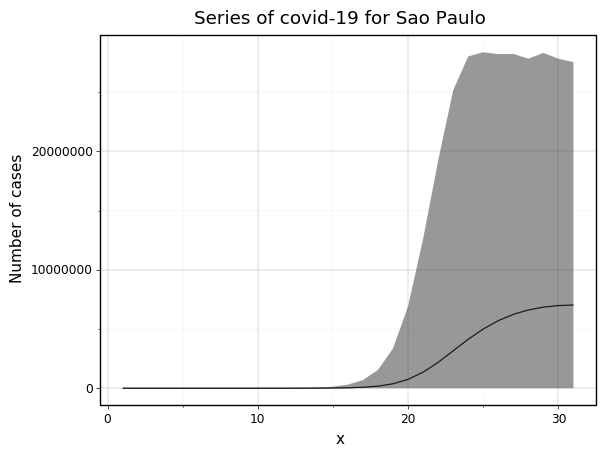

<ggplot: (8768894793992)>

In [8]:
(ggplot(dfs) + 
    geom_line(aes(x = "x", y = "mean")) +
    geom_ribbon(aes(x = "x", ymin = "q1", ymax = "q2"), alpha = 0.5) +
     ggtitle("Series of covid-19 for Sao Paulo") +
    ylab("Number of cases"))